## Background / Motivation

What motivated you to work on this problem?

Mention any background about the problem, if it is required to understand your analysis later on.

WOMP (Wellness, Optimization, Medical Patient) Project is aimed at understanding the interplay of hospital treatments (including diagnosis, hospital-administered tests and drugs) and various patient data points in the context of diabetes care. We have a general interest in using data to generate better healthcare outcomes. The medical field can benefit from the determination of trends in medical procedure and outcomes that can not be easily understood without large aggregate data.


## Problem statement 

Describe your four questions. Articulate your questions using absolutely no jargon. 

Fanyi: What factors (i.e., demographics and hospital treatments) are associated with length of hospital stay for the diabetic patients? 

Yuki: How is the number of emergency visits related to the demographics of patients, and number of inpatient treatment for the patient?

Antonio: 1)Who is receiving the most lab procedures and at what rate? 2) What are the characteristics of those who are readmitted? 


## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

Link to dataset: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

The dataset includes ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks [1]. The total number of observations in the original database was 101766. After removing duplicate observations and two observations with gender unspecified, the final dataset includes 71,515 observations. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab tests performed, HbA1c test result, diagnosis, number of medications, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc. The total number of categorical variables is 40, and the total  number of continuous variables is 8. Our variables of interest are  time_in_hospital, readmitted, number_emergency, num_procedures.
- Number of Observations = 101766 Number of Categorical Variables = 40 Number of Continuous Variables = 8
- Variables of Interest = time_in_hospital, readmitted, number_emergency, num_procedures, num_medications

## Stakeholders
Who cares? If you are successful, what difference will it make to them?

The stakeholders a healthcare providers, hospital administrators, as well as patients and their families.

This research project centers around the interplay of hospital treatments (including diagnosis, hospital-administered tests and drugs) and various patient data points in the context of diabetes care. The result of our study holds significant promise for the stakeholders of the Northwestern Medicine (NM) ecosystem: healthcare providers and hospitals under NM can better understand the relationships between factors like readmission rates, length of stay, prior emergency visits, and procedural interventions that can lead to more informed and tailored treatment decisions. This, in turn, enhances patient outcomes, reduces healthcare costs, and optimizes resource allocation. For example, if it is found that some drugs are less effective or rarely prescribed, we may suggest that hospitals stockpile less of these drugs.

## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

There were no incorrect values of variables, however we did some regrouping to reduce the number of levels for age, weight, and readmission rate variables.

The analysis required to eliminate the duplicated patient information as data preparation before ready to use. We also excluded observations without gender information.

In [1]:
#| echo: false

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk # machine learning library

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
  
# data (as pandas dataframes) 
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets 
  
# metadata 
# print(diabetes_130_us_hospitals_for_years_1999_2008.metadata) 
  
# variable information 
# print(diabetes_130_us_hospitals_for_years_1999_2008.variables) 

/Users/fanyimo/Desktop/STAT303_GROUP/ucimlrepo/fetch.py:100: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [2]:
#| echo: false

ids = diabetes_130_us_hospitals_for_years_1999_2008.data.ids
data = diabetes_130_us_hospitals_for_years_1999_2008.data.features

data = data.join(ids)

data["readmitted"] = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

data = data.drop_duplicates(subset=["patient_nbr"], keep='first')

data = data.loc[data.gender!="Unknown/Invalid",:]

data.to_csv('diabetes_data.csv')

In [3]:
#| echo: false

#[0-10), [10-20), [20-30), [30-40), [40-50) , [50-60) as 1
#[60-70), [70-80) as 1.5
#[80-90), [90-100) as 2

map_age = {'[0-10)':1,'[10-20)':1, '[20-30)':1, '[30-40)':1, '[40-50)':1,'[50-60)':1,'[60-70)':1.5, '[70-80)':1.5,'[80-90)':2,'[90-100)':2}
#existing values are dict keys, new values are dict values
data['age_group']=data['age'].map(map_age)


map_readmitted = {'<30':'Yes', '>30':'Yes', 'NO':'No'}
#existing values are dict keys, new values are dict values
data['readmitted_group']=data['readmitted'].map(map_readmitted)

map_weight = {'[0-25)':1,'[25-50)':1, '[50-75)':1, '[75-100)':2, '[100-125)':2,'[125-150)':3,'[150-175)':3, '[175-200)':3,">200":3}
#existing values are dict keys, new values are dict values
data['weight_group']=data['weight'].map(map_weight)


subset=data[data.number_emergency!=0]
subset2=data[data.number_emergency==0]

 Length of hospital stay

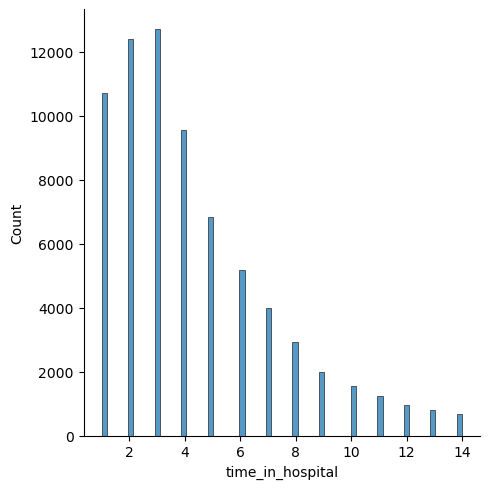

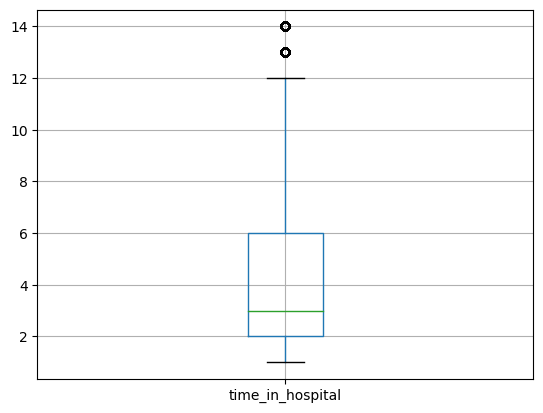

proportion of outliers of time in hospital is 0.020471229811927567


In [5]:
#| echo: false
# number of days in hostpital distribution 
sns.displot(data,x='time_in_hospital',kind='hist')
plt.show()

ax = data.boxplot(column = 'time_in_hospital')
plt.show()
# the lower and upper lines are Tukey's fences 
    # anything outside the fences are outliers 
    
# find the fence values
q1 = np.percentile(data['time_in_hospital'],25)
q3 = np.percentile(data['time_in_hospital'],75)

iqr = q3 -q1

lower_fence = q1-1.5*iqr
upper_fence = q3+1.5*iqr

print('proportion of outliers of time in hospital is', data.loc[((data.time_in_hospital<lower_fence) | (data.time_in_hospital>upper_fence)), :].shape[0]/data.shape[0])


Number of Emergency:

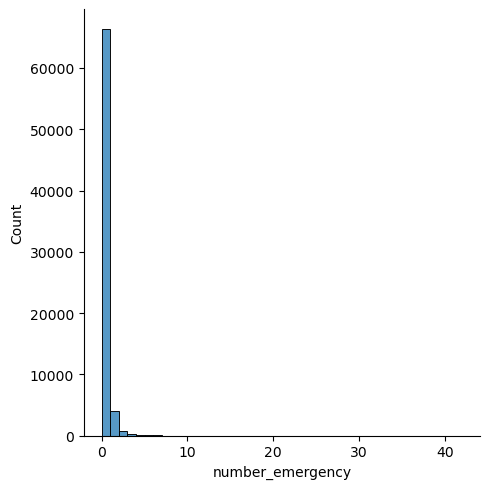

In [18]:
#| echo: false
sns.displot(data = data, x = 'number_emergency', kind = 'hist',binwidth=1) # 'kind =' is necessary for displot, not necessary for histplot()

plt.show()

Number of Lab Procedures:

## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

### Analysis 1
*By Fanyi Mo*


Fanyi’s analyses: factors associated with length of hospital stay
	
    
To understand factors associated with length of stay (variable: time in hospital), I further divide the issue into two subquestions: 1) what demographic factors may be associated with time in hospital; 2) what medical procedures may be associated with time in hospital. 

To answer 1), I looked into distribution of time in hospital for the two gender groups and the ten age groups. For the gender group, since the number of observations are roughly equal for both men (47% of the observations)  and women (53% of the observations), boxplots were used to compare the distributions. The boxplot shows that the overall distributions of the two gender follow the same pattern: both are slightly right-skewed and with interquartile ranges equal to 4. However, the medians are slightly different: female patients tend to spend 4 days, one day more than male patients (3 days) in hospital. 


median of male time in hospital: 3.0
median of female time in hospital: 4.0
iqr male = 4.0
iqr female = 4.0


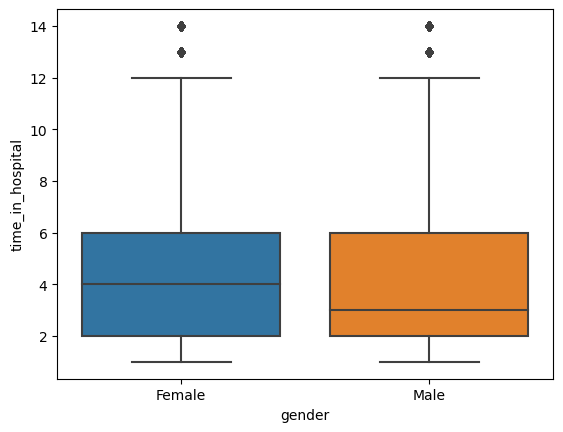

In [7]:
#| echo: false
b = sns.boxplot(data = data,x = 'gender', y = 'time_in_hospital')
for i in b.containers:
    b.box_label(i,)
    
print('median of male time in hospital:', data.loc[data.gender=='Male','time_in_hospital'].median())
print('median of female time in hospital:', data.loc[data.gender=='Female','time_in_hospital'].median())
    
q1_male = np.percentile(data.loc[data.gender=='Male','time_in_hospital'],25)
q3_male = np.percentile(data.loc[data.gender=='Male','time_in_hospital'],75)

iqr_male = q3_male -q1_male
print('iqr male =', iqr_male)

q1_female = np.percentile(data.loc[data.gender=='Female','time_in_hospital'],25)
q3_female = np.percentile(data.loc[data.gender=='Female','time_in_hospital'],75)

iqr_female = q3_female -q1_female
print('iqr female =', iqr_female)

Age in the dataset is defined as 10 age groups each spanning across 10 years. The youngest group is 0-10 yrs, and the oldest group is 90-100 yrs. Although number of observations varied across groups,I decided to keep the age groups as they are without any further binning to avoid missing nuances specific to each age group. The boxplot shows that, as expected, time in hospital is longer for the older age groups, although variations in time in hospital are also greater for the older groups, especially for those between age 60 and 80. For instance, the interquartile  range for the [50-60) group is 3 while that for the [60-70) group is 4. All distributions are right skewed. 


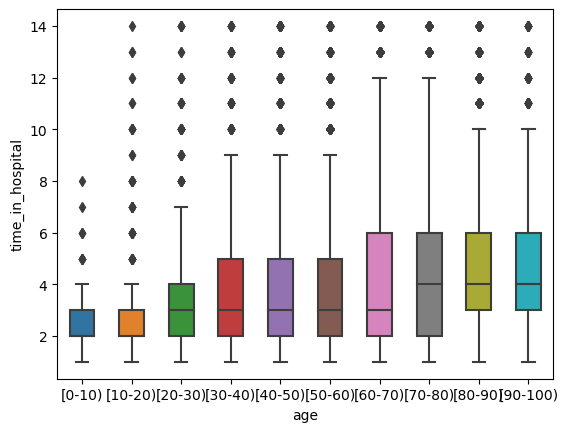

iqr 60-70 = 4.0
iqr 50-60 = 3.0


In [8]:
#| echo: false
#age vs. time-in-hospital
box=sns.boxplot(data = data,x = 'age', y = 'time_in_hospital',width=0.5)
plt.show()

q1_60 = np.percentile(data.loc[data.age=='[60-70)','time_in_hospital'],25)
q3_60 = np.percentile(data.loc[data.age=='[60-70)','time_in_hospital'],75)

iqr_60 = q3_60 -q1_60
print('iqr 60-70 =', iqr_60)

q1_50 = np.percentile(data.loc[data.age=='[50-60)','time_in_hospital'],25)
q3_50 = np.percentile(data.loc[data.age=='[50-60)','time_in_hospital'],75)

iqr_50 = q3_50 -q1_50
print('iqr 50-60 =', iqr_50)

To answer 2) what medical procedures may be associated with time in hospital, I first calculated the pairwise correlations between time in hospital and all the quantifiable hospital procedures (i.e., the numeric variables). The results are shown in the heatmap below. Inspecting the last row – pairwise correlations of other variables with time in hospital, number of lab procedures and number of medications stood out as the top two most correlated variables. Therefore, I decided to take a closer look at them incorporating the age group variable as we observe variations in their distributions in the boxplot above. 

/var/folders/ql/dg2rjzdn2x5f014frlw624ww0000gn/T/ipykernel_41073/632689030.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.iloc[:,7:15].corr(),vmin=0, vmax=1, annot=True)


<Axes: >

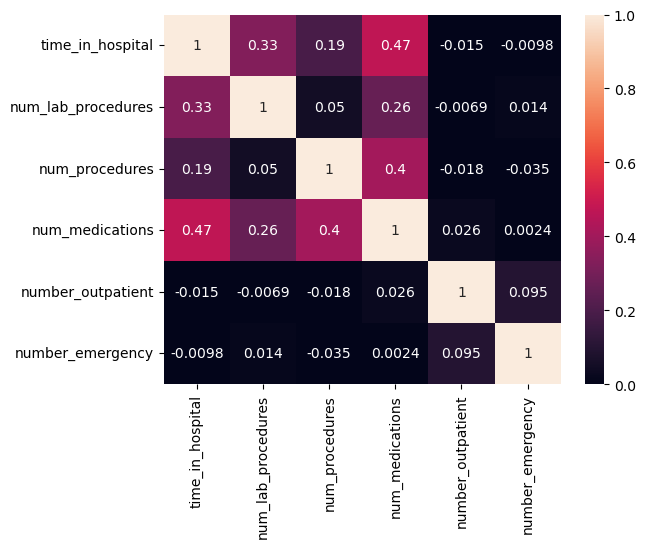

In [10]:
#| echo: false
sns.heatmap(data.iloc[:,7:15].corr(),vmin=0, vmax=1, annot=True)

As shown in the following subplot of regplots, number of medications seems to have number of medications seems  to have about equal strength of association with length of stay. Calculations of specific associations for each age group showed a slight increase in the slope of the best fit line between number of medications and time in hospital. For instance, the slope for the [20-30) group is around 0.15 while that for the [70-80) group is slightly greater than 0.19. It should be noted that the number of observations for the two groups are much lower than those for the older groups. The wider 95% confidence intervals for the younger groups indicates higher uncertainty with regards to the associations. 


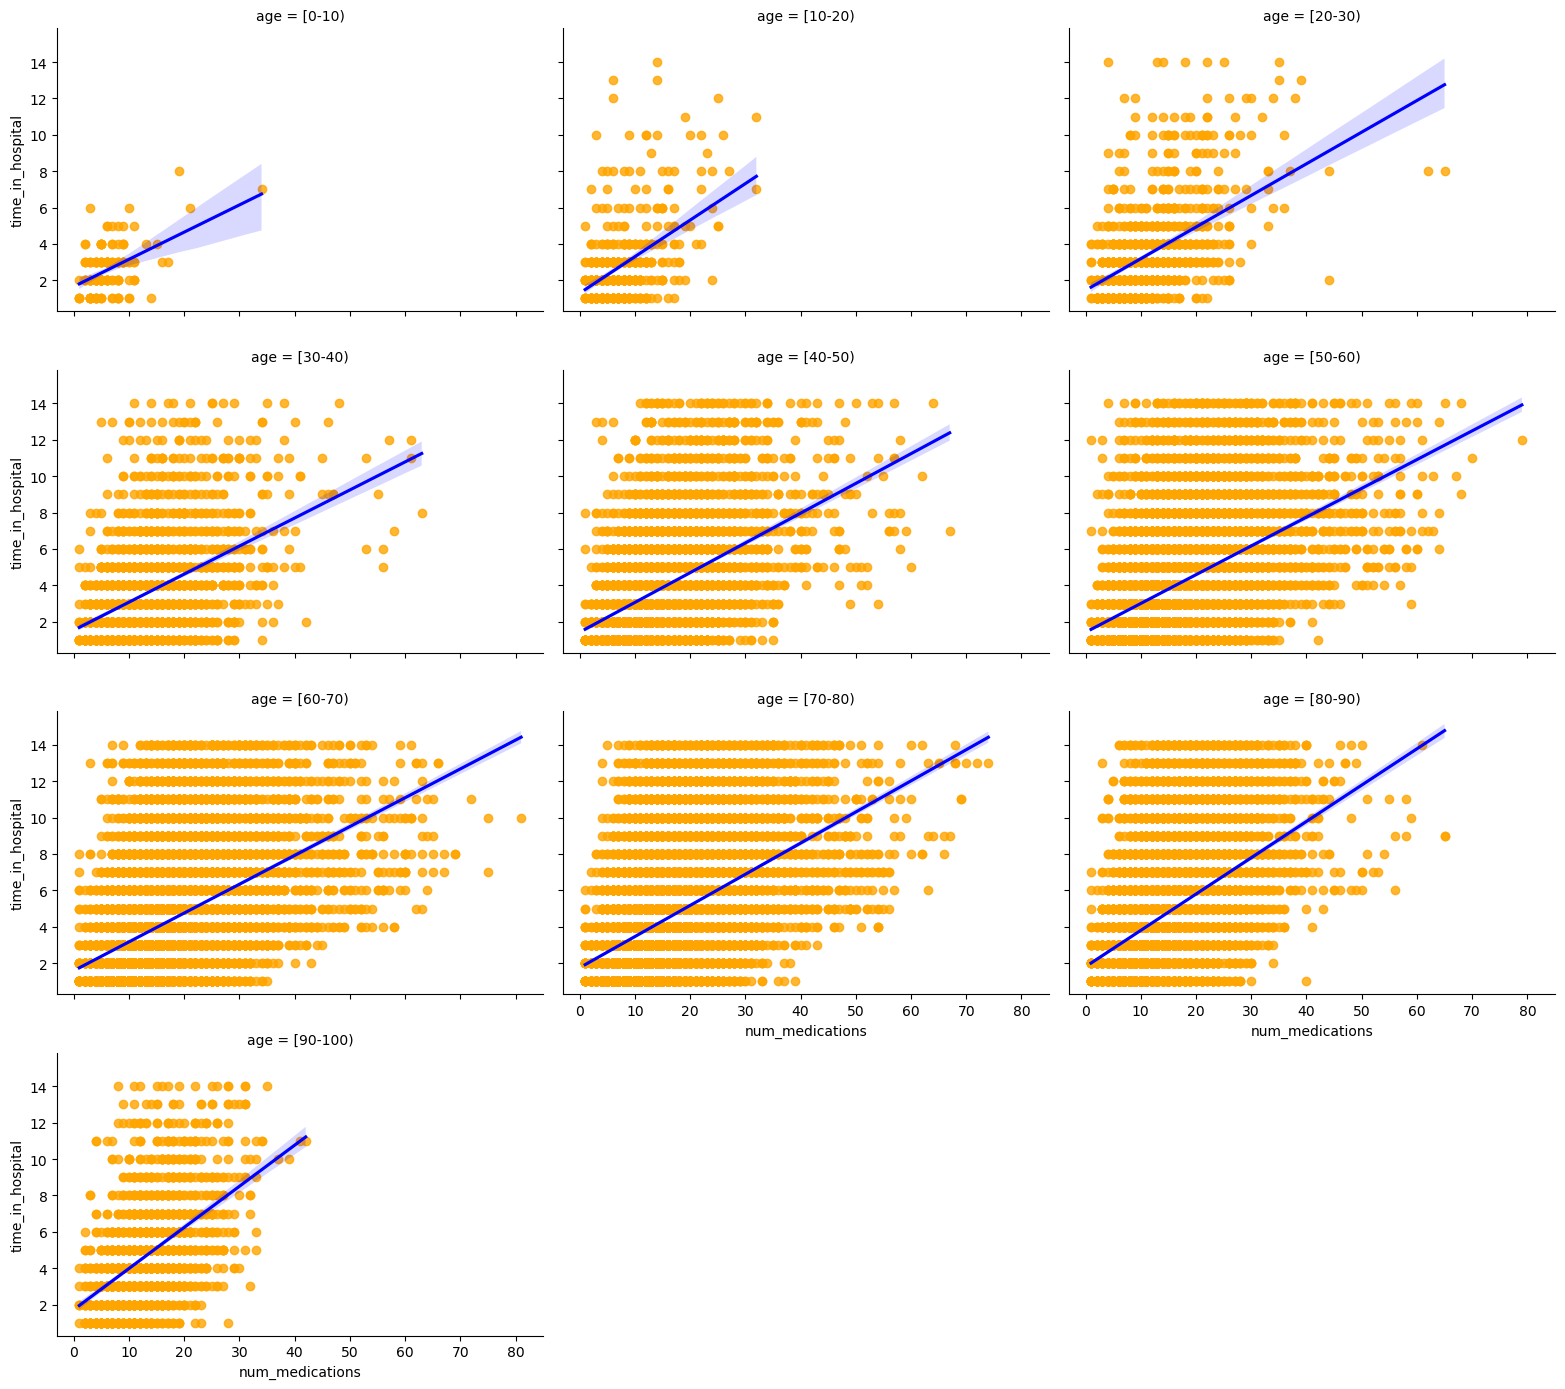

In [12]:
#| echo: false
#taking age into account for medications vs. time in hospital
b = sns.FacetGrid(data, col = 'age', col_wrap = 3, height=3.5, aspect=1.5)

b.map(sns.regplot, 'num_medications', 'time_in_hospital',scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
plt.show()

For number of lab procedures, as shown in the regplots below, slopes of fitted lines are higher for older age groups, number of lab procedure seems to be increasingly associated with length of stay as age increases. For example, the slope of the [20-30) group is 0.018, while that of the [60-70) group is 0.052.  As in the last graph, we should also notice that the 95% confidence intervals become narrower for older age group – due to larger samples for those groups. 


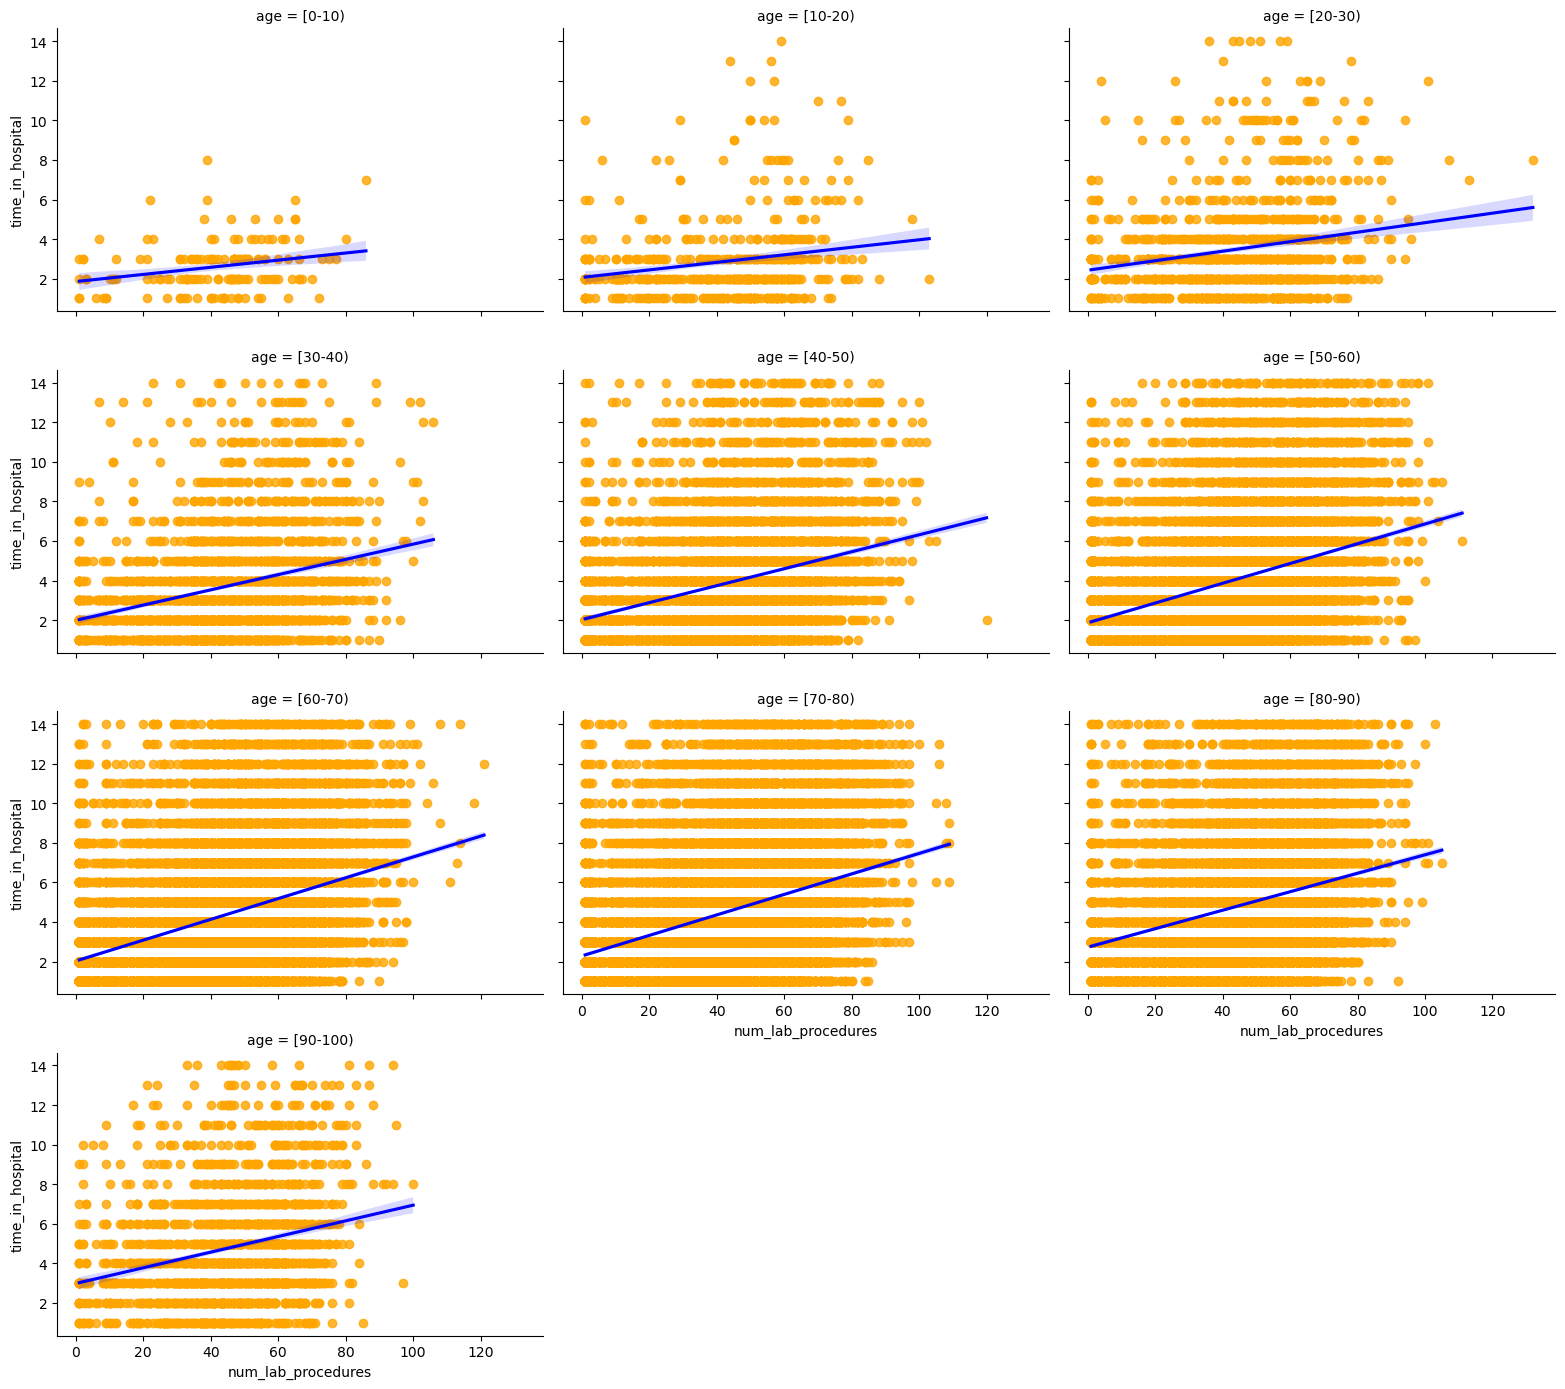

In [13]:
#| echo: false
#taking age into consideration
a = sns.FacetGrid(data, col = 'age', col_wrap = 3, height=3.5, aspect=1.5)

a.map(sns.regplot, 'num_lab_procedures', 'time_in_hospital',scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
plt.show()


As shown by the graphs above, length of stay in hospital differs across different demographic groups. Although the distributions are all right-skewed, there are differences in their central tendencies (as in the case of median stays for males and females) and variations (as in the case of differing interquartile ranges for the age groups). The number of medications and the number of lab procedures seemed to have the highest predictive power with respect to time in hospital.But as we take into account age, the associations seemed to differ for different age groups. Therefore, to better understand length of hospital stay for diabetic patients and use it as a model for allocating resources, hospital administrators and medical practitioners  should not only focus on the aggregated data, but really delve into specific demographic groups since patterns and strengths could very well be variant for younger versus older diabetic patients. 



### Analysis 2
By Yuki Han

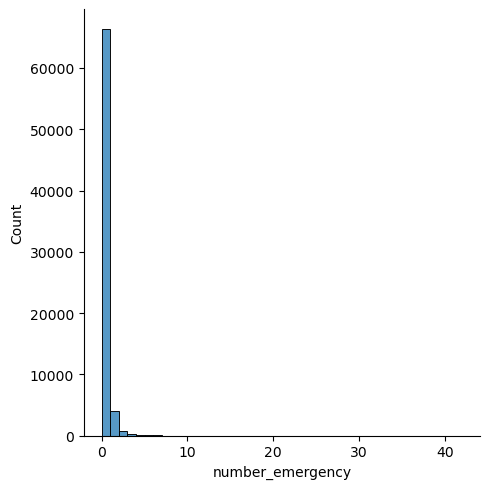

In [19]:
#| echo: false
sns.displot(data = data, x = 'number_emergency', kind = 'hist',binwidth=1) # 'kind =' is necessary for displot, not necessary for histplot()

plt.show()

Looking at the distribution of this varaible, it was demonstrated on the histogram that most of the patients eventually admitted to the hospital for diabetes never visited the emergency room prior to admission, as the distribution is heavily skewed. 

#### Are any of the demographics are associated with the number of emergency visits

From this distribution, it leads to the question of whether any of the demographics are associated with the number of emergency visits. In order to do this, I plotted the number of emergency visits by age and gender, as shown below. 

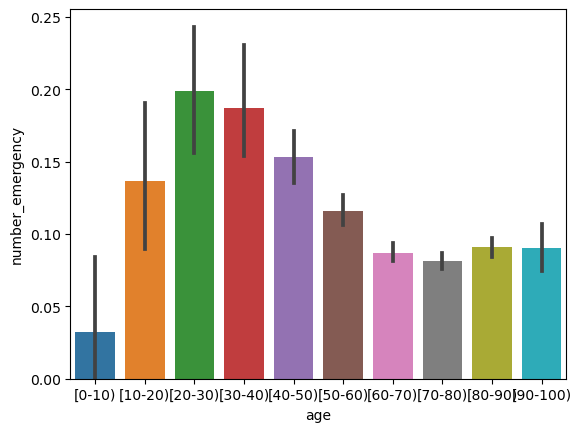

In [20]:
#| echo: false
sns.barplot(x="age", y="number_emergency", data = data)
plt.show()

In [8]:
data.groupby("age")['number_emergency'].agg(['mean','std'])

,mean,std
age,,
[0-10),0.032468,0.266147
[10-20),0.136449,0.598123
[20-30),0.198758,0.765299
[30-40),0.187106,1.019184
[40-50),0.153242,0.732161
[50-60),0.115915,0.550353
[60-70),0.087161,0.412986
[70-80),0.081503,0.395438
[80-90),0.090862,0.360900


By age group, it is shown that patients with an age range from 20 to 50 (M(20-30)= 0.20, M(30-40)= 0.19, M(40-50)= 0.15) have a higher average of emergency visits compared to other age groups. 


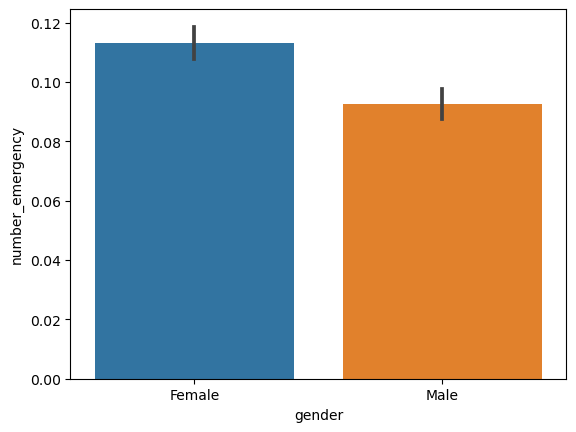

In [9]:
sns.barplot(x="gender", y="number_emergency", data = data)
plt.show()

In [10]:
data.groupby("gender")['number_emergency'].agg(['mean','std'])

,mean,std
gender,,
Female,0.113241,0.539966
Male,0.092535,0.471602


It is shown that by gender group, female (M= 0.11, SD = 0.54) has a higher average number of emergency visits compared to male (M =0.09, SD = 0.47): 

#### Demographics of patients who have never been to emergency visits by age group

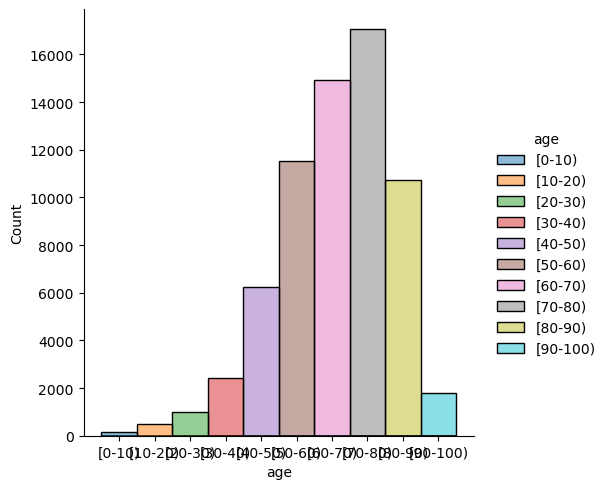

In [13]:
sns.displot(data = subset2, x = 'age', kind = 'hist',hue='age') # 'kind =' is necessary for displot, not necessary for histplot()

plt.show()

It is shown here that a lot of patients at the age range from 50 to 90 never went to the emergency room before. The difference in average emergency room visits by age groups can provide important information in preparing and distributing medical resources in the emergency room. Moreover, the difference in number of emergency visits by gender and age may also indicate the difference in the development of symptoms over time in terms of different demographics backgrounds.


#### Correlation between the number of emergency visits and the number of inpatient treatment before admission to hospital

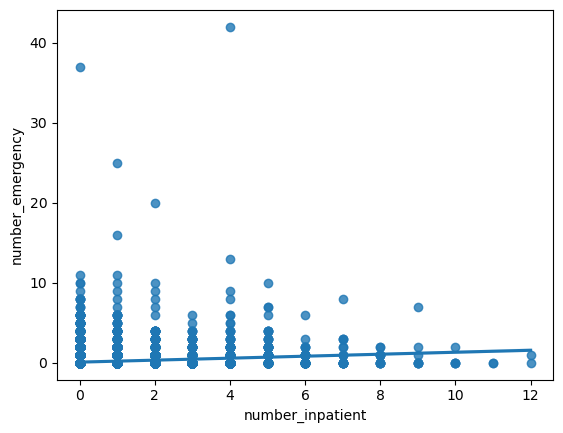

In [14]:
sns.regplot(data = data, x = 'number_inpatient', y='number_emergency') 
# sns.histplot() also works
plt.show()

From the distribution plot, we see that there is a positive correlation between the number of emergency visits and the number of inpatient treatment before admission to hospital, r= 0.15. 


#### Conclusion

To conclude, we can see that the number of emergency visits, although does not have large variance, can still provide important information on how to optimize the health system for the benefits of both stakeholders and patients based on demographics. 


### Analysis 3
*By \<Name of person doing the analysis>*


My questions were 1)Who is receiving the most lab procedures and at what rate? 2) What are the characteristics of those who are readmitted? The num_lab_procedures variable corresponds to the number of lab procedures that the patient was given during their visit (integer). The readmitted variable tells us if the patient returned after their initial visit. Responses were categorical and were either rated as no (no record of readmission), > 30 days (returned in more than 30 days), or <30 days(returned in less than 30 days). With these descriptions in mind, the first question I asked was who is receiving these lab procedures and at what rate?

In my first graph, I explore the distribution of num_lab_procedures for males and females. For reference, across the data set, there were a total of 71,515 patients with  38,025 of them being female and 33,490 of them males. We can clearly see that both groups follow a nearly normal distribution. There is a bar that juts out at the 0 mark indicating that a large group of participants in both gender categories receive no procedures. From this graph we can determine that there is no difference in the two groups, meaning no gender is receiving more lab procedures than the other.  


In my second set of graphs, I faceted the graphs to reflect the race column. Within this data set, race was categorized as either Cacassain, African American, Asian, Hispanic, or other. From the purple histogram graphs, it is immediately noticeable that our data set likely disproportionately represents a caucasian population. The values are as follows: Caucasian =         53,491, AfricanAmerican= 12,887, Hispanic = 1,517, Asian= 497, Other=1,177. This begs a variety of questions: are there SES factors that prevent other races from attaining medical care, are there social norms that differ across races about going to the hospital, do caucasian people suffer rates of diabetes higher than other races, etc. Regardless of this finding, we can still rescale the other races to show the distributions. The blue graphs show us that all the races in this data set are normally distributed and no one race category receives more lab procedures than the others. 


The next group to compare is the age groups. Ages are grouped by a factor of 10 years starting from 0 and ending at 100, 10 groups total. By creating a box and whiskers plot of the age groups, we see that across  all age groups the median number of procedures received is 44. This number has shown up in all of our data visualizations thus far. This number most likely corresponds to a standard procedure/panel of tests that patients receive. Getting a little deeper under the hood, we can look at the distributions of the age groups using a violin plot. From the violin plots we can see the emergence of second peaks in the distribution. For example in the case of the 90-100 age group, we can clearly see that there is a second grouping of patients that require more lab procedures.


Moving over now to readmission rates, I used a simple count plot to explore the data further. From the first count plot, we see that the majority of patients that are admitted do not return (42,982 patients). Those that do return typically come more than 30 days later from the initial visit (22,240 patients). However, if we facet the count plots to reflect age groupings, this changes. From the 0-50 age groupings, this initial pattern of patients not returning holds. However, when we get to the age groups [50-60] and [70-80], we now see that the majority of patients do return after the initial visit. 


From the graphs presented above, we discovered that the standard lab procedure rate across the hospital systems that was sampled in this data set hovers at the 44 mark. We determined that no one group is receiving more or less procedures, however some age groups have an emerging second peak in their distribution that requires more testing in some of the age categories. We also learned that the majority of diabetes patients that are admitted do not return after the initial visit. However, certain age groups do not follow this general pattern. For the stakeholders, there are valuable insights from this data set we can learn and apply in the Northwestern Medical systems. For our research teams at NU, it would be interesting to see if the disproportionality in the race category holds true in our system. If so, a study could reveal if these are SES related factors. If so, grants and government programs may be beneficial in helping low SES communities receive better diabetic care. For the stockpiling of drugs, lab procedures, and supplies, the readmission rates are important. For example, a basic algorithm could be put into place to monitor the age groupings of diabetic patients who are admitted in a given week. If for some reason there is an anomaly where in a given week, a large group of 50-60 year olds are admitted, this would alert the hospital that there could be a possible strain in diabetic supplies and tests in 30+ days. These findings can help the NU ecosystem be proactive in helping diabetic patient communities as well providing smoother care to diabetic patients in future follow up visits. 


## Other sections

You are welcome to introduce additional sections or subsections, if required, to address your questions in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 

## References {-}

[1]  Clore,John, Cios,Krzysztof, DeShazo,Jon, and Strack,Beata. (2014). Diabetes 130-US hospitals for years 1999-2008. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.
